In [1]:
import lightkurve as lk
import astropy.table as astab
import pandas as pd
import numpy as np
import astropy
from astropy.coordinates import SkyCoord
from astropy import units as u
import matplotlib.pyplot as plt
from matplotlib.gridspec import GridSpec
from tqdm import tqdm
# %pylab inline
# pylab.rcParams['figure.figsize'] = (16, 8)
import warnings
import astropy.table as astab
from astropy.io import fits

warnings.filterwarnings('ignore',
    message="WARNING (theano.tensor.opt): Cannot construct a scalar test value from a test value with no size:"
)
print(astropy.__version__)

import pymc3 as pm
import pymc3_ext as pmx
import aesara_theano_fallback.tensor as tt
from celerite2.theano import terms, GaussianProcess
import exoplanet as xo

import arviz as az
from corner import corner

from scipy.signal import savgol_filter

# %matplotlib widget
dd = "/Users/kjaehnig/CCA_work/GAT/"

4.3.1


# LOAD IN ALLVISIT FILE (an absolute unit: ~ 2.75GB)

In [2]:
allvis17 = astab.Table.read("/Users/kjaehnig/CCA_work/GAT/dr17_joker/allVisit-dr17-synspec.fits",hdu=1, format='fits')
print(len(allvis17['APOGEE_ID']))
print(allvis17.columns)

2659178
<TableColumns names=('APOGEE_ID','TARGET_ID','VISIT_ID','FILE','FIBERID','CARTID','PLATE','MJD','TELESCOPE','SURVEY','FIELD','PROGRAMNAME','ALT_ID','LOCATION_ID','RA','DEC','GLON','GLAT','RELFLUX','MTPFLUX','J','J_ERR','H','H_ERR','K','K_ERR','SRC_H','WASH_M','WASH_M_ERR','WASH_T2','WASH_T2_ERR','DDO51','DDO51_ERR','IRAC_3_6','IRAC_3_6_ERR','IRAC_4_5','IRAC_4_5_ERR','IRAC_5_8','IRAC_5_8_ERR','IRAC_8_0','IRAC_8_0_ERR','WISE_4_5','WISE_4_5_ERR','TARG_4_5','TARG_4_5_ERR','WASH_DDO51_GIANT_FLAG','WASH_DDO51_STAR_FLAG','PMRA','PMDEC','PM_SRC','AK_TARG','AK_TARG_METHOD','AK_WISE','SFD_EBV','APOGEE_TARGET1','APOGEE_TARGET2','APOGEE_TARGET3','APOGEE_TARGET4','TARGFLAGS','SNR','STARFLAG','STARFLAGS','DATEOBS','JD','VLSR','VGSR','CHISQ','SYNTHFILE','MIN_H','MAX_H','MIN_JK','MAX_JK','VREL','VRELERR','VHELIO','BC','RV_TEFF','RV_LOGG','RV_FEH','RV_CARB','RV_ALPHA','XCORR_VREL','XCORR_VRELERR','XCORR_VHELIO','CCFWHM','AUTOFWHM','RV_CHI2','N_COMPONENTS','RV_COMPONENTS','RV_FLAG')>


#### Load in relevant cross-matches and grab Joker Params for specific TIC ID

In [12]:
target_tic = 'TIC 20215452'

#cross-matched star table (has source_id, apogee_id, TIC_id)
hq_jk_allstar_tess_edr3 = astab.Table.read(dd+'dr17_joker/unimodal_joker_sample_joined_w_tess_edr3.fits', format='fits')
print(hq_jk_allstar_tess_edr3.columns)

#Adrian's calibrated RV_ERRs
calibverr = astab.Table.read(dd+'dr17_joker/allVisit-dr17-synspec-calib-verr.fits', format='fits', hdu=1)

# Grab cross-match IDs
jk_row = hq_jk_allstar_tess_edr3[hq_jk_allstar_tess_edr3['ID'] == int(target_tic.split(' ')[1])]


sysapodat = allvis17[allvis17['APOGEE_ID'] == jk_row['APOGEE_ID']]

## joining calib RV_ERRs with the RVs
sysapodat = astab.join(sysapodat, calibverr, keys=('VISIT_ID','VISIT_ID'))




<TableColumns names=('APOGEE_ID','n_visits','MAP_P','MAP_P_err','MAP_e','MAP_e_err','MAP_omega','MAP_omega_err','MAP_M0','MAP_M0_err','MAP_K','MAP_K_err','MAP_v0','MAP_v0_err','MAP_s','MAP_s_err','MAP_t0_bmjd','t_ref_bmjd','baseline','MAP_ln_likelihood','MAP_ln_prior','max_unmarginalized_ln_likelihood','max_phase_gap','periods_spanned','phase_coverage','phase_coverage_per_period','unimodal','joker_completed','mcmc_completed','mcmc_status','gelman_rubin_max','constant_ln_likelihood','robust_constant_ln_likelihood','robust_constant_mean','robust_constant_scatter','robust_constant_success','robust_linear_ln_likelihood','robust_linear_a','robust_linear_b','robust_linear_scatter','robust_linear_success','FILE','TELESCOPE','LOCATION_ID','FIELD','RA','DEC','J','H','K','APOGEE_TARGET1','APOGEE_TARGET2','APOGEE2_TARGET1','APOGEE2_TARGET2','APOGEE2_TARGET3','APOGEE2_TARGET4','NVISITS','SNR','STARFLAG','ANDFLAG','VHELIO_AVG','VSCATTER','VERR','N_COMPONENTS','GAIAEDR3_SOURCE_ID','GAIAEDR3_PARALLAX

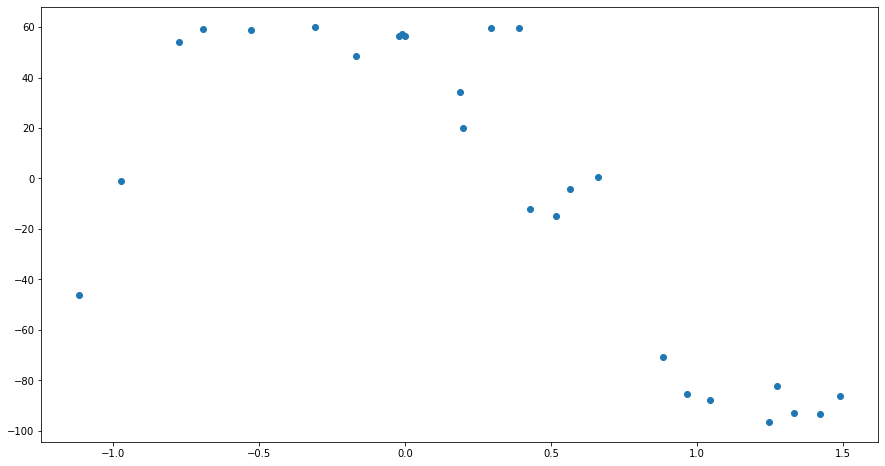

In [13]:
#### DEFINE THE RV,RV_ERRs, and X_RVs for later use in the mcmc... DO NOT REDEFINE ME OR YOU MAKE PYMC3 SAD
x_rv = sysapodat['JD'] 
xrv_sorted_ind = np.argsort(x_rv)

x_rv = x_rv[xrv_sorted_ind]
y_rv = sysapodat['VHELIO'][xrv_sorted_ind]
yerr_rv = sysapodat['CALIB_VERR'][xrv_sorted_ind]

fit,ax = plt.subplots(nrows=1, figsize=(15,8))
## ((x_rv - lit_t0 + 0.5 * lit_period) % lit_period) - 0.5 * lit_period, y_rv, ".k")
# ax.plot(((x_rv -min(x_rv) + 0.5*jk_row['MAP_P']) % jk_row['MAP_P']) - 0.5 * jk_row['MAP_P'], y_rv)
ax.scatter(((x_rv -min(x_rv) + 0.5*jk_row['MAP_P']) % jk_row['MAP_P']) - 0.5 * jk_row['MAP_P'], y_rv)

### Load TESS data for the APOGEE TARGET (there may not be any (yay!))

In [14]:
target_lk = lk.search_lightcurve(target_tic,
             mission='TESS',
            cadence='short',
            author='SPOC'
             )
print(target_lk)
unpro_lks = target_lk.download_all(quality_bitmask='hardest')
lks = unpro_lks[0].remove_nans().normalize().flatten()


SearchResult containing 1 data products.

 #     mission     year author exptime target_name distance
                                  s                 arcsec 
--- -------------- ---- ------ ------- ----------- --------
  0 TESS Sector 24 2020   SPOC     120    20215452      0.0


In [15]:
with fits.open(unpro_lks[0].filename) as hdu:
    hdr = hdu[1].header

texp = hdr["FRAMETIM"] * hdr["NUM_FRM"]
texp /= 60.0 * 60.0 * 24.0
print(texp, texp*60*60*24)


0.001388888888888889 120.00000000000003


In [16]:
# lks = ppt_flux.remove_nans()  #[lks.remove_nans()]
# lks = lks.remove_outliers(sigma_lower=10**6)
period_grid = np.exp(np.linspace(np.log(0.1), np.log(100),1000))
star1_bls = lks.to_periodogram('bls',
                                period=period_grid,
                                frequency_factor = 2000, duration=np.linspace(0.001,0.09,100))
star1_per = star1_bls.period_at_max_power
star1_t0 = star1_bls.transit_time_at_max_power
star1_dur = star1_bls.duration_at_max_power
star1_depth = star1_bls.depth_at_max_power
print(star1_per, star1_t0, star1_dur, star1_depth)

0.5953533130814371 d 1956.3037526548212 0.0379 d 0.09922235146687314


In [17]:
star1_mask = lks.create_transit_mask(period=star1_per.value, 
                                     duration=3.*star1_dur.value, 
                                     transit_time=star1_t0.value,
                                    )

In [18]:
period_grid = np.exp(np.linspace(np.log(0.1), np.log(100),1000))
star2_lks = lks[~star1_mask]
star2_bls = star2_lks.to_periodogram('bls',
                                period=period_grid,
                                frequency_factor = 2000, duration=np.linspace(0.001,0.09,100))
star2_per = star2_bls.period_at_max_power
star2_t0 = star2_bls.transit_time_at_max_power
star2_dur = star2_bls.duration_at_max_power
star2_depth = star2_bls.depth_at_max_power

lks_ref = min(lks.time.value)

<AxesSubplot:xlabel='Phase [JD]', ylabel='Normalized Flux'>

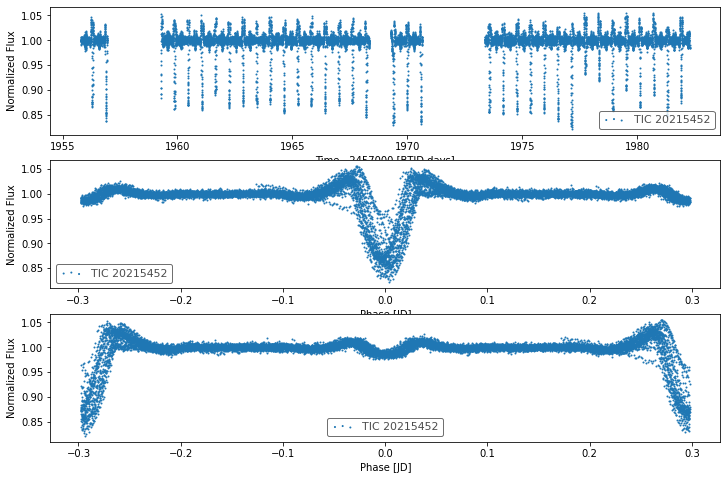

In [19]:
fig,ax = plt.subplots(nrows=3, figsize=(12,8))
lks.scatter(ax=ax[0])
lks.fold(period=star1_per, epoch_time=star1_t0).scatter(ax=ax[1])
lks.fold(period=star2_per, epoch_time=star2_t0).scatter(ax=ax[2])

In [21]:
primary_phase = lks.time.value[np.argmin(lks.flux.value)]%star1_per.value
secondary_phase = star2_lks.time.value[np.argmin(star2_lks.flux.value)]%star2_per.value
print(primary_phase, secondary_phase)

0.5717733439376049 0.26387005944074204


#### create function for one stop LK and RV processing

In [125]:
def generate_folded_lightcurve_rv_data(TICid):
    
    #cross-matched star table (has source_id, apogee_id, TIC_id)
    hq_jk_allstar_tess_edr3 = astab.Table.read(dd+'dr17_joker/unimodal_joker_sample_joined_w_tess_edr3.fits', format='fits')
#     print(hq_jk_allstar_tess_edr3.columns)

    #Adrian's calibrated RV_ERRs
    calibverr = astab.Table.read(dd+'dr17_joker/allVisit-dr17-synspec-calib-verr.fits', format='fits', hdu=1)

    # Grab cross-match IDs
    jk_row = hq_jk_allstar_tess_edr3[hq_jk_allstar_tess_edr3['ID'] == int(TICid.split(' ')[1])]

    sysapodat = allvis17[allvis17['APOGEE_ID'] == jk_row['APOGEE_ID']]

    ## joining calib RV_ERRs with the RVs
    sysapodat = astab.join(sysapodat, calibverr, keys=('VISIT_ID','VISIT_ID'))

    x_rv = sysapodat['JD'] 
    xrv_sorted_ind = np.argsort(x_rv)

    x_rv = x_rv[xrv_sorted_ind]
    y_rv = sysapodat['VHELIO'][xrv_sorted_ind]
    yerr_rv = sysapodat['CALIB_VERR'][xrv_sorted_ind]
    
    target_lk = lk.search_lightcurve(TICid,
                 mission='TESS',
                cadence='short',
                author='SPOC'
                 )
    print(target_lk)
    unpro_lks = target_lk.download_all(quality_bitmask='hardest')

    lks = unpro_lks.stitch().remove_nans().normalize().flatten()
    period_grid = np.exp(np.linspace(np.log(0.1), np.log(100),1000))
    star1_bls = lks.to_periodogram('bls',
                                    period=period_grid,
                                    frequency_factor = 2000, duration=np.linspace(0.001,0.09,100))
    star1_per = star1_bls.period_at_max_power
    star1_t0 = star1_bls.transit_time_at_max_power
    star1_dur = star1_bls.duration_at_max_power
    star1_depth = star1_bls.depth_at_max_power
    print(star1_per, star1_t0, star1_dur, star1_depth)
    
    x = lks.time.btjd
    y = lks.flux.value
    yerr = lks.flux_err.value
    x_lk_ref = min(x)

    x_rv = x_rv  - 2457000 - x_lk_ref

    x = x - x_lk_ref 
    y = (y / np.median(y) - 1)

    y *= 1e3
    
    lit_t0 = star1_t0.value - x_lk_ref
    lit_period = star1_per.value
    folded_x = (x - lit_t0 + 0.5 * lit_period) % lit_period - 0.5 * lit_period
    
    folded_x_rv = ((x_rv - star1_t0.tcb.jd + 0.5 * lit_period) % lit_period) - 0.5 * lit_period
#     ((x_rv - star1_t0.tcb.jd + 0.5 * lit_period) % lit_period) - 0.5 * lit_period, y_rv, ".k")
    return (folded_x, y),(folded_x_rv.value, y_rv.value),(jk_row['MAP_P'].value,star1_per.value, jk_row['APOGEE_ID'].value)

In [126]:
plotdat = generate_folded_lightcurve_rv_data("TIC 20215452")

SearchResult containing 1 data products.

 #     mission     year author exptime target_name distance
                                  s                 arcsec 
--- -------------- ---- ------ ------- ----------- --------
  0 TESS Sector 24 2020   SPOC     120    20215452      0.0


/Users/kjaehnig/CCA_work/GAT/gatenv/lib/python3.9/site-packages/lightkurve/lightcurve.py:1051: LightkurveWarning: The light curve already appears to be in relative units; `normalize()` will convert the light curve into relative units for a second time, which is probably not what you want.
  warnings.warn(


0.5953533130814371 d 1956.3037526548212 0.0379 d 0.09922235146687314


In [127]:
print(plotdat[2])

(array([3.06779099]), 0.5953533130814371, array([b'2M15091604+3602002'], dtype='|S30'))


In [128]:
tic_ids = [
    165453878,
    169820068,
    20215452,
    258108067,
    271548206,
    272074664,
    28159019,
    30313682,
    9429166,
    99254945
]
print(len(tic_ids))
print(0%2)

tic_plotdat = [generate_folded_lightcurve_rv_data("TIC "+str(ii)) for ii in tic_ids]

10
0
SearchResult containing 3 data products.

 #     mission     year author exptime target_name distance
                                  s                 arcsec 
--- -------------- ---- ------ ------- ----------- --------
  0 TESS Sector 15 2019   SPOC     120   165453878      0.0
  1 TESS Sector 16 2019   SPOC     120   165453878      0.0
  2 TESS Sector 22 2020   SPOC     120   165453878      0.0


/Users/kjaehnig/CCA_work/GAT/gatenv/lib/python3.9/site-packages/lightkurve/lightcurve.py:1051: LightkurveWarning: The light curve already appears to be in relative units; `normalize()` will convert the light curve into relative units for a second time, which is probably not what you want.
  warnings.warn(
`period` contains 231182 points.Periodogram is likely to be large, and slow to evaluate. Consider setting `frequency_factor` to a higher value.


2.7066520700332415 d 1712.499922577071 0.09000000000000001 d 0.025310862232704786


SearchResult containing 2 data products.

 #     mission     year author exptime target_name distance
                                  s                 arcsec 
--- -------------- ---- ------ ------- ----------- --------
  0 TESS Sector 14 2019   SPOC     120   169820068      0.0
  1 TESS Sector 15 2019   SPOC     120   169820068      0.0


/Users/kjaehnig/CCA_work/GAT/gatenv/lib/python3.9/site-packages/lightkurve/lightcurve.py:1051: LightkurveWarning: The light curve already appears to be in relative units; `normalize()` will convert the light curve into relative units for a second time, which is probably not what you want.
  warnings.warn(


54.04216420705917 d 1708.6955276450353 0.0891 d 0.11124612682058307
SearchResult containing 1 data products.

 #     mission     year author exptime target_name distance
                                  s                 arcsec 
--- -------------- ---- ------ ------- ----------- --------
  0 TESS Sector 24 2020   SPOC     120    20215452      0.0


/Users/kjaehnig/CCA_work/GAT/gatenv/lib/python3.9/site-packages/lightkurve/lightcurve.py:1051: LightkurveWarning: The light curve already appears to be in relative units; `normalize()` will convert the light curve into relative units for a second time, which is probably not what you want.
  warnings.warn(


0.5953533130814371 d 1956.3037526548212 0.0379 d 0.09922235146687314
SearchResult containing 2 data products.

 #     mission     year author exptime target_name distance
                                  s                 arcsec 
--- -------------- ---- ------ ------- ----------- --------
  0 TESS Sector 24 2020   SPOC     120   258108067      0.0
  1 TESS Sector 25 2020   SPOC     120   258108067      0.0


/Users/kjaehnig/CCA_work/GAT/gatenv/lib/python3.9/site-packages/lightkurve/lightcurve.py:1051: LightkurveWarning: The light curve already appears to be in relative units; `normalize()` will convert the light curve into relative units for a second time, which is probably not what you want.
  warnings.warn(


13.005112521734095 d 1966.4175057804985 0.09000000000000001 d 0.01780068135721177
SearchResult containing 3 data products.

 #     mission     year author exptime target_name distance
                                  s                 arcsec 
--- -------------- ---- ------ ------- ----------- --------
  0 TESS Sector 14 2019   SPOC     120   271548206      0.0
  1 TESS Sector 15 2019   SPOC     120   271548206      0.0
  2 TESS Sector 40 2021   SPOC     120   271548206      0.0


/Users/kjaehnig/CCA_work/GAT/gatenv/lib/python3.9/site-packages/lightkurve/lightcurve.py:1051: LightkurveWarning: The light curve already appears to be in relative units; `normalize()` will convert the light curve into relative units for a second time, which is probably not what you want.
  warnings.warn(
`period` contains 2702094 points.Periodogram is likely to be large, and slow to evaluate. Consider setting `frequency_factor` to a higher value.


72.25349491787219 d 1732.1281585779054 0.0891 d 0.2108891173935556
SearchResult containing 3 data products.

 #     mission     year author exptime target_name distance
                                  s                 arcsec 
--- -------------- ---- ------ ------- ----------- --------
  0 TESS Sector 14 2019   SPOC     120   272074664      0.0
  1 TESS Sector 15 2019   SPOC     120   272074664      0.0
  2 TESS Sector 40 2021   SPOC     120   272074664      0.0


/Users/kjaehnig/CCA_work/GAT/gatenv/lib/python3.9/site-packages/lightkurve/lightcurve.py:1051: LightkurveWarning: The light curve already appears to be in relative units; `normalize()` will convert the light curve into relative units for a second time, which is probably not what you want.
  warnings.warn(
`period` contains 2702094 points.Periodogram is likely to be large, and slow to evaluate. Consider setting `frequency_factor` to a higher value.


20.956623994804346 d 1688.5493063998376 0.09000000000000001 d 0.069871979398942
SearchResult containing 2 data products.

 #     mission     year author exptime target_name distance
                                  s                 arcsec 
--- -------------- ---- ------ ------- ----------- --------
  0 TESS Sector 14 2019   SPOC     120    28159019      0.0
  1 TESS Sector 15 2019   SPOC     120    28159019      0.0


/Users/kjaehnig/CCA_work/GAT/gatenv/lib/python3.9/site-packages/lightkurve/lightcurve.py:1051: LightkurveWarning: The light curve already appears to be in relative units; `normalize()` will convert the light curve into relative units for a second time, which is probably not what you want.
  warnings.warn(


4.6096044868284345 d 1684.5483470678817 0.09000000000000001 d 0.01976883164362079
SearchResult containing 12 data products.

 #     mission     year author exptime target_name distance
                                  s                 arcsec 
--- -------------- ---- ------ ------- ----------- --------
  0 TESS Sector 01 2018   SPOC     120    30313682      0.0
  1 TESS Sector 02 2018   SPOC     120    30313682      0.0
  2 TESS Sector 03 2018   SPOC     120    30313682      0.0
  3 TESS Sector 04 2018   SPOC     120    30313682      0.0
  4 TESS Sector 05 2018   SPOC     120    30313682      0.0
  5 TESS Sector 06 2018   SPOC     120    30313682      0.0
  6 TESS Sector 07 2019   SPOC     120    30313682      0.0
  7 TESS Sector 08 2019   SPOC     120    30313682      0.0
  8 TESS Sector 10 2019   SPOC     120    30313682      0.0
  9 TESS Sector 11 2019   SPOC     120    30313682      0.0
 10 TESS Sector 12 2019   SPOC     120    30313682      0.0
 11 TESS Sector 13 2019   SPOC     

/Users/kjaehnig/CCA_work/GAT/gatenv/lib/python3.9/site-packages/lightkurve/lightcurve.py:1051: LightkurveWarning: The light curve already appears to be in relative units; `normalize()` will convert the light curve into relative units for a second time, which is probably not what you want.
  warnings.warn(
`period` contains 636825 points.Periodogram is likely to be large, and slow to evaluate. Consider setting `frequency_factor` to a higher value.


8.588828559546254 d 1327.077159060418 0.09000000000000001 d 0.06585092676608553
SearchResult containing 1 data products.

 #     mission     year author exptime target_name distance
                                  s                 arcsec 
--- -------------- ---- ------ ------- ----------- --------
  0 TESS Sector 22 2020   SPOC     120     9429166      0.0


/Users/kjaehnig/CCA_work/GAT/gatenv/lib/python3.9/site-packages/lightkurve/lightcurve.py:1051: LightkurveWarning: The light curve already appears to be in relative units; `normalize()` will convert the light curve into relative units for a second time, which is probably not what you want.
  warnings.warn(


13.095350204826678 d 1913.3868548413918 0.0298 d 0.009009488461358536
SearchResult containing 1 data products.

 #     mission     year author exptime target_name distance
                                  s                 arcsec 
--- -------------- ---- ------ ------- ----------- --------
  0 TESS Sector 22 2020   SPOC     120    99254945      0.0


/Users/kjaehnig/CCA_work/GAT/gatenv/lib/python3.9/site-packages/lightkurve/lightcurve.py:1051: LightkurveWarning: The light curve already appears to be in relative units; `normalize()` will convert the light curve into relative units for a second time, which is probably not what you want.
  warnings.warn(


7.689283720758311 d 1901.7952219793171 0.09000000000000001 d 0.11380663068236394


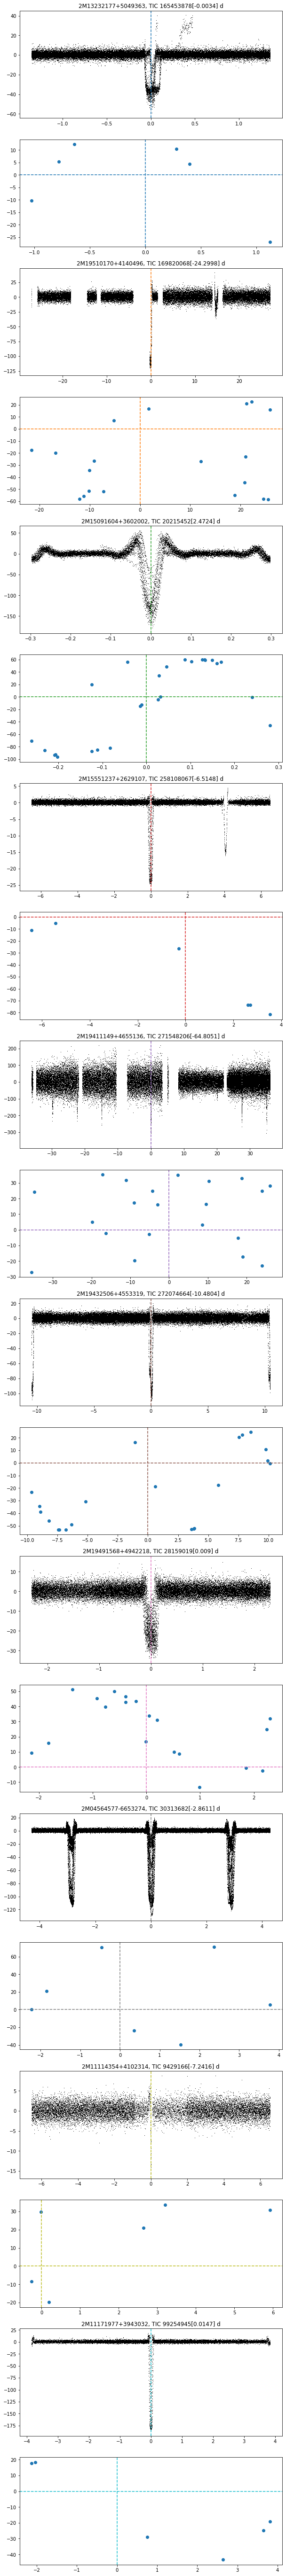

In [129]:
fig,axes = plt.subplots(nrows=20,ncols=1, figsize=(10,100))
for ii, tic in enumerate(tic_ids):
    map_p = tic_plotdat[ii][2][0]
    bls_p = tic_plotdat[ii][2][1]
    del_p = map_p - bls_p
    plotdat = tic_plotdat[ii]
    axes.flatten()[ii+1*ii].plot(plotdat[0][0],plotdat[0][1],',k')
    axes.flatten()[ii+1*ii+1].scatter(plotdat[1][0],plotdat[1][1])
    line_col = f'C{ii}'
    axes.flatten()[ii+1*ii].axvline(0.0,color=line_col,ls='--')
    axes.flatten()[ii+1*ii+1].axvline(0.0,color=line_col,ls='--')
    axes.flatten()[ii+1*ii+1].axhline(0.0,color=line_col,ls='--')

    apoid = tic_plotdat[ii][2][2][0].decode("utf-8")
    axes.flatten()[ii+1*ii].set_title(str(apoid)+', TIC '+str(tic_ids[ii]) + str(np.round(del_p,4))+" d")

In [ ]:
tic_plotdat